## 1. Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

## 2. Hilfsfunktionen

### Fläche berechnen

In [2]:
def getAreaSize(points):
    A = 0.0
    for i in range(0, len(points)-1):
        A += float(points[i][0]*points[i+1][1] - points[i+1][0]*points[i][1])
    A /= 2.0
    return A

### Geometrische Mitte berechnen

In [3]:
def getGeometricalCentroird(points):
    #Points have format [(x0,y0), ... ,(x_n-1,y_n-1) ,(x0,y0)]
    x_s = 0
    y_s = 0
    for i in range(0, len(points)-1):
         mult_term = (points[i][0]*points[i+1][1] - points[i+1][0]*points[i][1])
         x_s += (points[i][0] + points[i+1][0])*mult_term
         y_s += (points[i][1] + points[i+1][1])*mult_term
    areaSize = getAreaSize(points) 
    if areaSize != 0:
        x_s /= (6*areaSize)
        y_s /= (6*areaSize)
        return (x_s, y_s, areaSize)
    else:
        return (points[0][0], points[0][1], 0)

In [4]:
def getWeightedGeometricalCentroirds(pointList):
    if len(pointList) == 1:
        return pointList[0]
    
    #calculate weighted border centroid
    borderCentroid = pointList[0]
    (x,y,area) = borderCentroid
    weightedBorderCentroid = (x*area,y*area,area)
    
    #subtract weighted inner centroids
    weighted_inner_centroid = (0,0,0)
    for current_inner_centroid in pointList[1:]:
        (x, y, area) = current_inner_centroid
        (xSum, ySum, areaSum) = weighted_inner_centroid
        weighted_inner_centroid = (xSum + x*area ,ySum + y*area, areaSum + area)
        
    #calculate area-difference
    (xB,yB,areaB) = weightedBorderCentroid
    (xI,yI,areaI) = weighted_inner_centroid
    total_area = areaB - areaI

    
    if total_area == 0:
        return borderCentroid
    
    #calculate weighted centroid
    (x, y, area) = ( (xB - xI)/total_area, (yB- yI)/total_area,  total_area)
    

    
    return (x, y, area)
    
    

### Centroid

In [5]:
def getPointCentroid(points):
     #Points have format [(x0,y0), ... ,(x_n-1,y_n-1) ,(x0,y0)]
    (x_s, y_s) =  (0,0)
    
    for (x,y) in points[0:-1]:
        (x_s, y_s) = (x_s + x, y_s + y)
            
    amount = (len(points) -1)
    if amount == 0:
        return (points[0][0],points[0][1], amount)
    (x_s, y_s) =  (x_s/amount, y_s/amount)
    return (x_s, y_s, amount)

In [6]:
def getWeightedPointCentroirds(pointList):
    if len(pointList) == 1:
        return pointList[0]
    
    sum_points = 0
    centroid = (0,0,0)
    for (x,y,sum) in pointList:
        sum_points += sum
    for (x,y,sum) in pointList:
        if sum == 0:
            continue
        (xC, yC, sumC) = centroid
        weight = float(sum) / float(sum_points)
        centroid = (xC + x * weight, yC + y* weight, sumC + weight*sumC)
    return centroid
    

### Polygone aus FMI-lonlat-Format aus File lesen

In [7]:
def convertToPolygonList(pointlist):
    points = []
    index = 0;
    
    x_val = 0
    for coordinate in pointlist.split(" "):
        if index == 0:
            x_val = float(coordinate)
        else:
            y_val = float(coordinate)
            points.append((x_val, y_val))
        index = (index + 1)  %2
    if index != 0:
        print("There must me as many x as y-coordinates.")
        return
    return points

In [8]:
def import_lon_lat_file(path):
    polygon_families = []
    current_family = []
    fobj = open(path)
    current_reading_type = 0;
    count_inners = 0;
    current_inners = []
    parsed = 0
    
    for line in fobj:
        if current_reading_type == 0:
            current_outer = convertToPolygonList(line);
            current_reading_type = 1
            current_family.append(current_outer)
        elif current_reading_type == 1:
            count_inners = int(line)
            if count_inners > 0:
                current_reading_type = 2
                parsed = 0
            else:
                current_reading_type = 0
                polygon_families.append(current_family)
                current_family = []
        else:
            cur_inner = convertToPolygonList(line)
            current_inners.append(cur_inner)
            parsed = parsed +1
            if parsed >= count_inners:
                current_reading_type =0
                current_family.extend(current_inners)
                polygon_families.append(current_family)
                current_family = []
                current_inners = []
                current_reading_type = 0
        
    fobj.close()
    return polygon_families

In [9]:
def import_point_of_I_file (path):
    fobj = open(path)
    results = []
    for line in fobj:
            result_array = line.strip().split(" ")
            x = float(result_array[0])
            y = float(result_array[1])
            dist = float(result_array[2])
            results.append((x,y,dist))
    fobj.close()
    return results

### Linien aus FMI-lonlat-Format aus File lesen

In [10]:
def read_lines(path):
    fobj = open(path)
    results = []
    for line in fobj:
        subresult = []
        result_array = line.strip().split(" ")
        offset = 0;
        while offset + 3 < len(result_array):
            a = result_array[0 + offset]
            b = result_array[1 + offset]
            c = result_array[2 + offset]
            d = result_array[3 + offset]
            subresult.append([(a,b), (c,d)])
            offset = offset + 4
        results.append(subresult)
    return results

### Punkte aus FMI-lonlat-Format aus File lesen

In [11]:
def read_points(path):
    fobj = open(path)
    results = []
    for line in fobj:
        subresult = []
        result_array = line.strip().split(" ")
        offset = 0;
        while offset + 1 < len(result_array):
            a = result_array[0 + offset]
            b = result_array[1 + offset]
            subresult.append((a,b))
            offset = offset + 2
        results.append(subresult)
    return results

### Einzelne Punkte Plotten

In [12]:
def print_skeleton_central_points(pointarray, appearance):
    for point in pointarray:
        x = float(point[0])
        y = float(point[1])
        plt.plot(x, y, appearance,zorder=0)

### Einzelne Linen Plotten

In [13]:
def print_lines(lines, my_color, my_linewidth):
    for line in lines:
        x = [float(line[0][0]), float(line[1][0])]
        y = [float(line[0][1]), float(line[1][1])]
        plt.plot(x, y, linewidth=my_linewidth, color=my_color ,zorder=0)

## 3. Ergebnisse plotten




lon_lat_FMI_format/get_center_of_single_family_test:
(mit 1 Outer-Inner-Teilen)


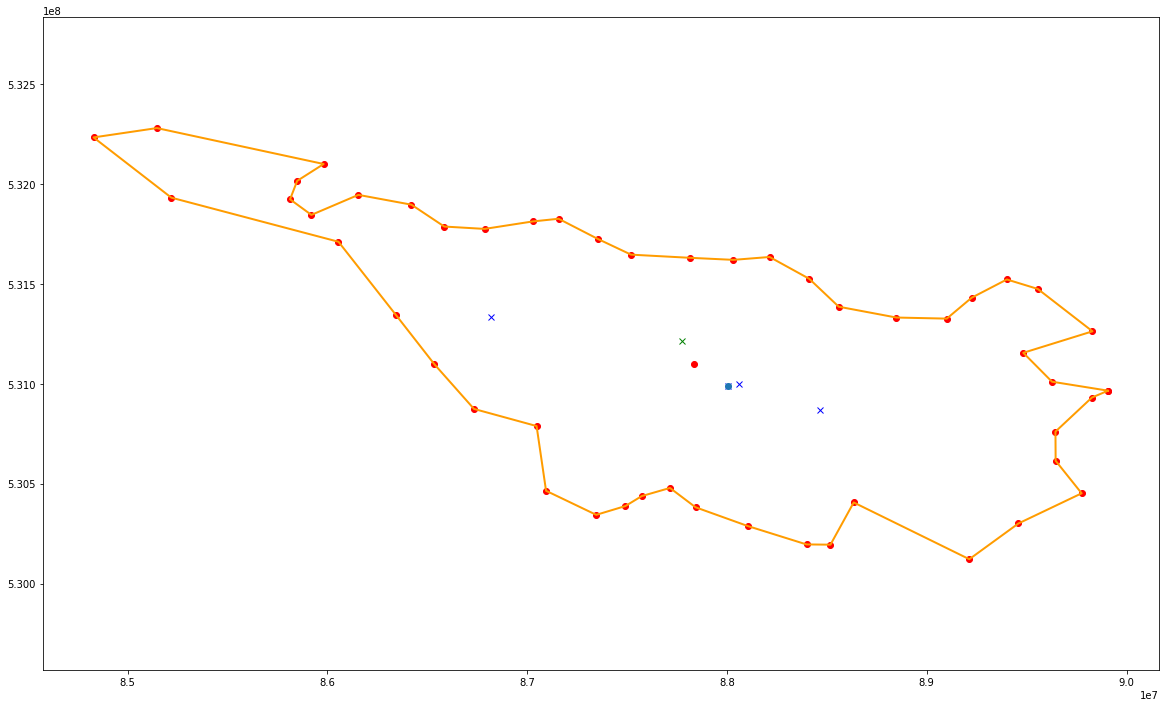

In [45]:
#filenames = ["good_PoI_example", "good_PoI_example2", "good_PoI_example3"]
filenames = ["get_center_of_single_family_test"]
#filenames = ["hufeisen"]
folder = "lon_lat_FMI_format/"
fileformat_plain           = ".txt"
fileformat_results         = ".result"
fileformat_diagonals       = ".diagonals"
fileformat_skeleton        = ".skeleton"
fileformat_skeleton_points_betweenness = ".skeleton_central_points_betweenness"
fileformat_skeleton_points_closeness = ".skeleton_central_points_closeness"
files = [folder + name for name in filenames]

rounds = -1
for currentFile in files:
    rounds = rounds + 1
    print("\n\n\n" + currentFile + ":")
    
    #plotsize
    plt.figure(figsize=(20,12))
    plt.axis('equal')
    #plt.autoscale(tight=False)
    
    #Load Polygonfamilies from file
    polygon_families = import_lon_lat_file(currentFile + fileformat_plain)
    
    #Load Results from RUST-Calculation: Point of Inaccessibility
    #polygon_family_PoI_centroid         = import_point_of_I_file(currentFile + fileformat_results)
    
    #load diagonal from RUST-Calculation: Polygon-Skeleton-Graph
    #polygon_triangulation_diagonals     = []#read_lines(currentFile + fileformat_diagonals)
    #polygon_triangulation_skeletons     = []#read_lines(currentFile + fileformat_skeleton)
    #polygon_skeletons_central_points_betweenness    = []#read_points(currentFile + fileformat_skeleton_points_betweenness)
    #polygon_skeletons_central_points_closeness      = []#read_points(currentFile + fileformat_skeleton_points_closeness)
    
    
    #color for holes
    inner_color = (0.7,0.7,0.4)
    
    print("(mit " + str(len(polygon_families)) + " Outer-Inner-Teilen)")
    
    polygongroup = 0
    
    for polygon_family in polygon_families:
        #Subresults
        geometricalCentroirds = []
        pointCentroirds = []
        
        #count groups
        polygongroup = polygongroup + 1
        
        is_outer_polygon = True
        for polygon in polygon_family:
    
            #Color holes sdifferently
            color = inner_color
            if is_outer_polygon:
                is_outer_polygon = False
                color = (1, 0.61, 0)

            #Split Pointarray to x and y values
            points = polygon
            x_koords = [x for (x,y) in points]
            y_koords = [y for (x,y) in points]

            #calculate subresults for Centroids
            geometricalCentroirds.append(getGeometricalCentroird(points))
            pointCentroirds.append(getPointCentroid(points))
            
            plt.plot(x_koords, y_koords, linewidth=2, solid_capstyle='round', color=color)
        
        #Plot Centroit of Polygon-family
        grouplabel = "Polygongruppe " + str(polygongroup) +":"
        
        (x_s, y_s, area_s) = getWeightedGeometricalCentroirds(geometricalCentroirds)
              
        if area_s > 0:
            plt.plot(x_s, y_s, 'or', label= grouplabel + 'geometric Centroid')
        
            (x_c, y_c, sum_c)  = getWeightedPointCentroirds(pointCentroirds)
            plt.plot(x_c, y_c, 'xg', label= grouplabel + 'average Centroid')
           
            #diagonals = polygon_triangulation_diagonals[polygongroup-1]
            #print_lines(diagonals,(0.9,0.9,0.9), 1)
            
            #skeleton = polygon_triangulation_skeletons[polygongroup-1]
            #print_lines(skeleton,(0.8,0,0), 1.5)
            
            #central_points_betweeness = polygon_skeletons_central_points_betweenness[polygongroup-1]
            #print_skeleton_central_points(central_points_betweeness, 'sy');
            
            #central_points_closeness = polygon_skeletons_central_points_closeness[polygongroup-1]
            #print_skeleton_central_points(central_points_closeness, 'Dg');
            
            print_skeleton_central_points(polygon, 'or');
            
            #(x, y, rad) = polygon_family_PoI_centroid[polygongroup-1]
            #plt.plot(x, y, '+b', label= grouplabel + 'Point of Inaccessibility (1.0 Precision)')
            #circle1 = plt.Circle((x, y), rad, color='b', fill=False)
            
            
            fig = plt.gcf()
            ax = fig.gca()
            #ax.add_artist(circle1)
            
            kandiadten =[(88062251.85573769, 530997112.56653786), (88464321.0, 530866533.0), (88005191.0, 530991016.0), (86820500.0, 531334203.0)]
            

            for (x,y) in kandiadten:
                plt.plot(x, y,  'xb')
                
            plt.plot(88005191.0, 530991016.0,  'o')

            
            fig.savefig("Output/" + filenames[rounds] + ".pdf")
            
        
    #plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.05))
    plt.show()
    
            

#Grün = Punkte Zentrieren
#Rot = Flächenschwrpunkt